In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import scipy as sp
from itertools import chain
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
import statsmodels.stats.weightstats
from matplotlib import path
from scipy.stats import probplot,shapiro, sem
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import cm
from numpy import linspace
import umap.umap_ as umap
#import pylab

from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import networkx as nx


import os
#import PIL
#from scipy.ndimage import gaussian_filter, uniform_filter1d

# Some Functions

In [2]:
print('THIS IS A GLOBAL VARIABLE. Do not change testeq_GW')
global testeq_GW
testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')

THIS IS A GLOBAL VARIABLE. Do not change testeq_GW


# generate a dataframe connecting directory with seq_name in their property df

In [3]:
%%time
seq_name_list = []
seq_name_dir = []
protein_name = []
for root, dirs, files in os.walk('IDROME_larsen/IDRome_v4/', topdown=False):
    for name in files:
        seq_name_list.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]+['_']+[root.split('/')[len(root.split('/'))-1]]))
        protein_name.append(''.join(root.split('/')[2:(len(root.split('/'))-1)]))
        seq_name_dir.append(root)
        break
seq_name_dir_df = pd.DataFrame(zip(seq_name_list,seq_name_dir,protein_name),columns=['seq_name','seq_dir','protein_uniprot_id'])
del seq_name_list, seq_name_dir, protein_name
seq_name_dir_df

CPU times: user 190 ms, sys: 1.31 s, total: 1.5 s
Wall time: 13.9 s


,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


# write function

In [4]:
# def compute_3dplot_from_seq_name(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
#     t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
#     t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
#     t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
#     t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
#     protein_df = t_df_moments[['RSA']].copy()
#     del t_df_moments
#     protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
#     protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
#     protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
#     #plt.close()
#     return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [5]:
def get_grid_protein(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments    

    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']    
    
    protein_rg2 = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_ree2 = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_ratio = protein_ree2/protein_rg2
    protein_rg_mean = np.mean(np.load(f'{example_protein_dir}/rg.npy'))
    protein_rg_by_rg_mean = np.load(f'{example_protein_dir}/rg.npy')/protein_rg_mean
    global grid_protein_size_shape, grid_protein_shape_shape, grid_protein_rg_rg_mean, grid_protein_Rs,grid_protein_RSA
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]
    p_total = []
    q_total = []
    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    x_total.append(protein_rg_by_rg_mean)
    y_total.append(protein_ratio)
    p_total.append(protein_df.RSA.values)
    q_total.append(protein_df.ratio.values)
    
    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))
    p_total=list(chain.from_iterable(p_total))
    q_total=list(chain.from_iterable(q_total))
    
#size shape portion
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    step_x=0.3#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=3#(
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x+1)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y+1)
    
    grid_protein_size_shape, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    #isolate the variable grids
    grid_protein_rg_rg_mean,_ = np.histogram(x_total,bins=gridx)
    grid_protein_Rs,_ = np.histogram(y_total,bins=gridy)
    
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])
    del xlims, ylims, max_x_val, max_y_val, n_divisions_x, n_divisions_y, step_x, step_y, gridx, gridy
#shape shape portion
    max_p_val=1
    max_q_val=30
    plims = [0,max_p_val]
    qlims = [0,max_q_val]
    
    step_p=0.1
    step_q=3
    max_value_p=max(plims)
    n_divisions_p=round((max_value_p-min(plims))/step_p)
    
    max_value_q=max(qlims)
    n_divisions_q=round((max_value_q-min(qlims))/step_q)
    
    gridp = np.linspace(min(plims), max(plims), n_divisions_p+1)
    gridq = np.linspace(min(qlims), max(qlims), n_divisions_q+1)
    
    grid_protein_shape_shape, _, _ = np.histogram2d(p_total, q_total, bins=[gridp, gridq])
    grid_protein_RSA,_ = np.histogram(p_total,bins=gridp)
    
    return

In [6]:
def compile_umap_df(provided_seq_list):
    j=0
    for provided_seq in provided_seq_list:
        if j==0:
            get_grid_protein(provided_seq)
            current_df_size = pd.DataFrame(grid_protein_rg_rg_mean,index=[f'size+{j}' for j in range(len(grid_protein_rg_rg_mean))]).T
            current_df_Rs = pd.DataFrame(grid_protein_Rs,index=[f'ratio+{j}' for j in range(len(grid_protein_Rs))]).T
            current_df_RSA = pd.DataFrame(grid_protein_RSA,index=[f'RSA+{j}' for j in range(len(grid_protein_RSA))]).T        
            current_df_total = pd.concat([current_df_size,current_df_Rs,current_df_RSA],axis=1)
            current_df_total.insert(0,'peptID',provided_seq)
            master_df = current_df_total.copy()
        else:
            get_grid_protein(provided_seq)
            current_df_size = pd.DataFrame(grid_protein_rg_rg_mean,index=[f'size+{j}' for j in range(len(grid_protein_rg_rg_mean))]).T
            current_df_Rs = pd.DataFrame(grid_protein_Rs,index=[f'ratio+{j}' for j in range(len(grid_protein_Rs))]).T
            current_df_RSA = pd.DataFrame(grid_protein_RSA,index=[f'RSA+{j}' for j in range(len(grid_protein_RSA))]).T        
            current_df_total = pd.concat([current_df_size,current_df_Rs,current_df_RSA],axis=1)
            current_df_total.insert(0,'peptID',provided_seq)
            master_df = pd.concat([master_df,current_df_total]).copy()
        j+=1
    return master_df

In [7]:
#two functions here -- to plot 2d map
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [8]:
def compute_3dplot_from_seq_name(seq_name):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

# get 2d conformation shape plot at different nu values (run in order, see j value in each cell) (ALL ~28000 sequences)

In [7]:
%%time
#do not run

#all_seq_list = seq_name_dir_df['seq_name'].to_list()
#master_df = compile_umap_df(all_seq_list).copy()

CPU times: user 1h 35min 22s, sys: 3min 55s, total: 1h 39min 18s
Wall time: 1h 54min 59s


In [8]:
#do not run 
#master_df = master_df.reset_index(drop=True)
#master_df

,peptID,size+0,size+1,size+2,size+3,size+4,size+5,size+6,size+7,size+8,...,RSA+0,RSA+1,RSA+2,RSA+3,RSA+4,RSA+5,RSA+6,RSA+7,RSA+8,RSA+9
0,H0YL14_1_46,0,0,339,499,148,14,0,0,0,...,21,105,181,170,170,155,109,70,19,0
1,H0YL09_1_131,0,2,365,442,168,23,0,0,0,...,34,146,189,170,181,125,79,64,12,0
2,H0YKK7_1_89,0,3,378,435,157,27,0,0,0,...,29,127,156,157,171,140,122,74,23,1
3,H0YKK7_135_164,0,0,338,509,145,8,0,0,0,...,20,100,163,164,181,141,129,74,28,0
4,H0YKK7_430_550,0,0,352,488,143,17,0,0,0,...,25,116,156,185,168,152,116,67,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,A3QJZ6_111_153,0,1,362,475,147,15,0,0,0,...,20,116,161,169,154,150,112,85,33,0
28054,A3QJZ7_106_152,0,0,356,462,162,20,0,0,0,...,35,140,172,169,160,132,106,67,18,1
28055,A3KN83_1001_1044,0,1,353,487,149,9,1,0,0,...,22,110,185,150,159,140,129,85,20,0
28056,A3KN83_1_250,0,4,352,477,150,15,2,0,0,...,23,121,174,163,185,165,100,58,11,0


In [6]:
##master_df.to_csv('all_seq_box_df_using_size-shape-shape-individually.csv')
#master_df = pd.read_csv('all_seq_box_df_using_size-shape-shape-individually.csv')
#master_df = master_df.reset_index(drop=True)

In [9]:
idrome_prop_df = pd.read_csv('combined_idrome_prop_df.csv')
#idrome_prop_df = pd.concat([master_df.set_index('peptID'),idrome_prop_df.set_index('seq_name')],axis=1)
#del master_df

In [8]:
#idrome_prop_df['extra_nu_cat']=['<=0.45' if nu_<=0.45 else '>0.55' if nu_>0.55 else '>0.45 & <=0.55' for nu_ in idrome_prop_df.nu.values]

# looking into some properties

In [13]:
idrome_prop_df.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'nu_err', 'S_err', 'Delta_err', 'ete2_Rg2_err',
       'Rg', 'Rg_err', 'ete', 'ete_err', 'rh', 'rh_err', 'R0', 'R0_err',
       'SPR_err'],
      dtype='object')

In [24]:
idrome_prop_df.faro.describe()

count    28058.000000
mean         0.054032
std          0.036510
min          0.000000
25%          0.028571
50%          0.049057
75%          0.073171
max          0.357143
Name: faro, dtype: float64

In [25]:
idrome_prop_df[idrome_prop_df.nu<=0.45].faro.describe()

count    616.000000
mean       0.054477
std        0.043821
min        0.000000
25%        0.027836
50%        0.048004
75%        0.068405
max        0.357143
Name: faro, dtype: float64

100000 GW snapshots completed
200000 GW snapshots completed
300000 GW snapshots completed
400000 GW snapshots completed
500000 GW snapshots completed
600000 GW snapshots completed
700000 GW snapshots completed
800000 GW snapshots completed
900000 GW snapshots completed
1000000 GW snapshots completed


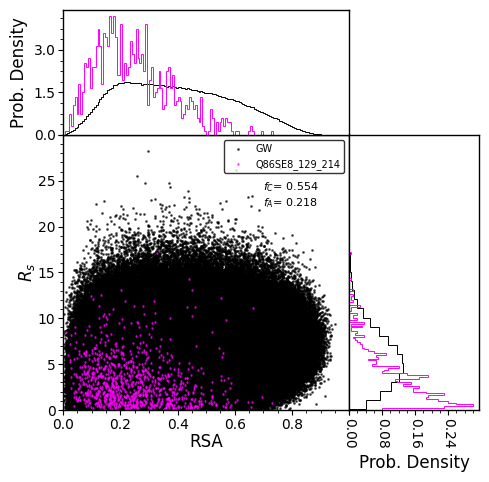

In [12]:
compute_3dplot_from_seq_name('Q86SE8_129_214')

In [15]:
idrome_prop_df[['fasta','fD']]

,fasta,fD
0,EEEEEEEGEEEEEEEEDDEDEDADISLEEQSPVKQVKRLVPQKQAS...,0.069767
1,KRHRALSQAAVEEEEEEEEEEEPAQGKGDSIEEILADSEDEEDNEE...,0.058824
2,MKARRNKKQIPSFRKLIKTSKVKLENKLKNKQFKQQSTLKKYRKEQ...,0.064356
3,RAKGKSEAGKKGPGRPTGSKKKNEPEDEEEEEEEEDEDEEEEDEDEE,0.106383
4,KNEEEGESKDEEDEDEDGGQKPEGEPQQDPGTEETYGEVEEEPLDE...,0.063694
...,...,...
28053,SDDKRASLDEDEDDDDEEDNDEDDNDEDDDDEDDDEAEDNDEDEDD...,0.520000
28054,PENHPQWDTAIEGDEDQEDSEGFEDSFEEEEEEEEDDD,0.210526
28055,EWLEETDSEEDSEEVEGAEGGVDDEDSGEESGAED,0.171429
28056,DEEGGEDDDDDDDDGDEGEEELEDIDEGDEDEGEEDEDDDEGEEGE...,0.396226


# this is for GO analysis

In [16]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
df_idrome

,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,Rh/nm,...,gene_name,QCDpred,z_delta_+-,z_omega_pi,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr
seq_name,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,1.403521,...,NUDT4B,0.254463,0.000000,0.000000,0.000000,0.000000,-0.531910,0.000000,0.565,10.288
A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,1.308675,...,TRAV6,0.659342,0.000000,0.054230,-0.043142,0.000000,0.061436,0.000000,0.532,10.107
A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,1.849274,...,TMEM265,0.661272,-1.094918,0.000000,0.384885,2.281943,1.092688,0.298507,0.537,10.167
A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,2.471343,...,KCNE1B,0.445861,0.000000,-0.463316,0.799692,0.000000,0.627563,0.000000,0.509,10.018
A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,1.582147,...,SPEGNB,0.313998,0.000000,0.000000,1.947253,0.000000,0.090132,0.369565,0.578,10.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,2.953329,...,KIF25-AS1,0.396007,0.000000,0.000000,-1.319891,0.000000,0.163169,0.000000,0.520,9.993
Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,3.457226,...,AFDN-DT,0.374082,0.000000,0.000000,-2.182869,0.000000,2.214949,0.000000,0.537,9.984
Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,2.351117,...,COLEC10,0.232155,0.106768,0.000000,0.451957,2.132808,1.114749,0.513761,0.513,10.072


In [17]:
GO_terms = pd.Series(pd.read_pickle('uniprot_dict.pkl')).to_dict()

In [18]:
GO_terms

{'A0A024RBG1': ['GO:0005737',
  'GO:0005829',
  'GO:0005634',
  'GO:0034431',
  'GO:0034432',
  'GO:0008486',
  'GO:0000298',
  'GO:0050072',
  'GO:0046872',
  'GO:0003723',
  'GO:1901911',
  'GO:1901909',
  'GO:1901907',
  'GO:0071543'],
 'A0A075B6T7': ['GO:0042101', 'GO:0002250', 'GO:0009617'],
 'A0A087WTH1': ['GO:0016021'],
 'A0A087WTH5': ['GO:0016021',
  'GO:0015459',
  'GO:0044325',
  'GO:0005249',
  'GO:0086011',
  'GO:0098915',
  'GO:1902260',
  'GO:0097623',
  'GO:0086091',
  'GO:0060307',
  'GO:0086005'],
 'A0A087WUL8': ['GO:0005737'],
 'A0A087WV53': ['unknown'],
 'A0A087WVF3': ['GO:0005886', 'GO:0005096', 'GO:0090630'],
 'A0A087WWA1': ['GO:0005942', 'GO:0046935', 'GO:0046854'],
 'A0A087WX78': ['unknown'],
 'A0A087WXM9': ['GO:0000779',
  'GO:0000776',
  'GO:0016321',
  'GO:0045143',
  'GO:0007060',
  'GO:0010789',
  'GO:0051754'],
 'A0A087WXS9': ['GO:0005886', 'GO:0005096', 'GO:0090630'],
 'A0A087X179': ['GO:0005886', 'GO:0005096', 'GO:0090630'],
 'A0A087X1G2': ['GO:0005886', 

In [57]:
#function written by Giulio Tesei
import urllib.parse
import urllib.request
import json

def map_to_curated_codes(graph, GO_terms, curated_GO_codes, nodes):
    new_codes = np.empty(0)
    for code in GO_terms:
        if code in nodes and code != 'unknown':
            ancestors = list(nx.dfs_predecessors(graph, source=code, depth_limit=None).values())
            ancestors += list(nx.dfs_predecessors(graph, source=code, depth_limit=None).keys())
            intersect = np.intersect1d(ancestors, curated_GO_codes)
            if intersect.size==0:
                intersect = np.append(intersect, 'other')
            new_codes = np.append(new_codes, intersect)
    return np.unique(new_codes).tolist()

def uniprot_api(uniprot):
    # Use the uniprot as input to fetch the protein name
    url_template_uniprot = "https://rest.uniprot.org/uniprotkb/{}.json"
    url_uniprot = url_template_uniprot.format(uniprot)

    with urllib.request.urlopen(url_uniprot) as link:
        #print(f'Extracting protein name for {uniprot}...')
        data_uniprot = json.loads(link.read().decode())
        #print(data_uniprot)

        try:
            go_list = []
            for count,value in enumerate(data_uniprot['uniProtKBCrossReferences']):
                if data_uniprot['uniProtKBCrossReferences'][count]["database"] == "GO":
                    go_id = data_uniprot['uniProtKBCrossReferences'][count]["id"]
                    #print(go_id)
                    go_list.append(go_id)
        except:
            go_id = "unknown"
            go_list.append(go_id)


        if len(go_list) == 0:
            go_id = "unknown"
            go_list.append(go_id)

        return go_list

In [22]:
for i,uniprot in enumerate(df_idrome.UniProt_ID.unique()):
    go = uniprot_api(uniprot)
    GO_terms[uniprot] = go
    print(i,end='-')

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-

KeyboardInterrupt: 

In [27]:
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
GO_dict = pd.Series(pd.read_pickle('uniprot_dict.pkl')).to_frame(name='GO')

In [31]:
GO_dict

,GO
A0A024RBG1,"[GO:0005737, GO:0005829, GO:0005634, GO:003443..."
A0A075B6T7,"[GO:0042101, GO:0002250, GO:0009617]"
A0A087WTH1,[GO:0016021]
A0A087WTH5,"[GO:0016021, GO:0015459, GO:0044325, GO:000524..."
A0A087WUL8,[GO:0005737]
...,...
Q9Y6Z4,[unknown]
Q9Y6Z5,[unknown]
Q9Y6Z7,"[GO:0005581, GO:0005737, GO:0009897, GO:000557..."
W6CW81,"[GO:0097169, GO:0003690, GO:0002218, GO:003545..."


In [29]:
df_idrome.UniProt_ID.unique().shape

(15424,)

In [32]:
np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum())

array(['GO:0000002', 'GO:0000003', 'GO:0000010', ..., 'GO:2001295',
       'GO:2001311', 'unknown'], dtype='<U10')

In [46]:
GO_dict.loc[df_idrome.UniProt_ID].GO

A0A024RBG1    [GO:0005737, GO:0005829, GO:0005634, GO:003443...
A0A075B6T7                 [GO:0042101, GO:0002250, GO:0009617]
A0A087WTH1                                         [GO:0016021]
A0A087WTH5    [GO:0016021, GO:0015459, GO:0044325, GO:000524...
A0A087WV53                                            [unknown]
                                    ...                        
Q9Y6Z4                                                [unknown]
Q9Y6Z5                                                [unknown]
Q9Y6Z7        [GO:0005581, GO:0005737, GO:0009897, GO:000557...
W6CW81        [GO:0097169, GO:0003690, GO:0002218, GO:003545...
X6R8D5                                                [unknown]
Name: GO, Length: 28058, dtype: object

In [45]:
GO_dict.loc[df_idrome.UniProt_ID].GO.sum()

['GO:0005737',
 'GO:0005829',
 'GO:0005634',
 'GO:0034431',
 'GO:0034432',
 'GO:0008486',
 'GO:0000298',
 'GO:0050072',
 'GO:0046872',
 'GO:0003723',
 'GO:1901911',
 'GO:1901909',
 'GO:1901907',
 'GO:0071543',
 'GO:0042101',
 'GO:0002250',
 'GO:0009617',
 'GO:0016021',
 'GO:0016021',
 'GO:0015459',
 'GO:0044325',
 'GO:0005249',
 'GO:0086011',
 'GO:0098915',
 'GO:1902260',
 'GO:0097623',
 'GO:0086091',
 'GO:0060307',
 'GO:0086005',
 'unknown',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005942',
 'GO:0046935',
 'GO:0046854',
 'unknown',
 'unknown',
 'GO:0000779',
 'GO:0000776',
 'GO:0016321',
 'GO:0045143',
 'GO:0007060',
 'GO:0010789',
 'GO:0051754',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005886',
 'GO:0005096',
 'GO:0090630',
 'GO:0005615',
 'GO

In [37]:
import obonet

In [41]:
name_to_id

{'mitochondrion inheritance': 'GO:0000001',
 'mitochondrial genome maintenance': 'GO:0000002',
 'high-affinity zinc transmembrane transporter activity': 'GO:0000006',
 'low-affinity zinc ion transmembrane transporter activity': 'GO:0000007',
 'alpha-1,6-mannosyltransferase activity': 'GO:0000009',
 'heptaprenyl diphosphate synthase activity': 'GO:0000010',
 'vacuole inheritance': 'GO:0000011',
 'single strand break repair': 'GO:0000012',
 'single-stranded DNA endodeoxyribonuclease activity': 'GO:0000014',
 'phosphopyruvate hydratase complex': 'GO:0000015',
 'lactase activity': 'GO:0000016',
 'alpha-glucoside transport': 'GO:0000017',
 'regulation of DNA recombination': 'GO:0000018',
 'regulation of mitotic recombination': 'GO:0000019',
 'mitotic spindle elongation': 'GO:0000022',
 'maltose metabolic process': 'GO:0000023',
 'maltose biosynthetic process': 'GO:0000024',
 'maltose catabolic process': 'GO:0000025',
 'alpha-1,2-mannosyltransferase activity': 'GO:0000026',
 'ribosomal large

In [38]:
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'
graph = obonet.read_obo(url)

id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [51]:
#print(name_to_id['molecular_function'],name_to_id['biological_process'],name_to_id['cellular_component'])
molfunc = list(nx.ancestors(graph, 'GO:0003674')) # all nodes connected to molecular function
bioproc = list(nx.ancestors(graph, 'GO:0008150')) # all nodes connected to biological process
cellcom = list(nx.ancestors(graph, 'GO:0005575')) # all nodes connected to cellular component

In [60]:
nodes_cat = cellcom

In [61]:
GO_terms = GO_dict.copy() 
    # Copy database
df_GO = df_idrome.copy()

g,u = np.unique(GO_dict.loc[df_idrome.UniProt_ID].GO.sum(),return_counts=True)
curated_GO_codes = g[u>=200]
curated_GO_codes = np.unique(np.intersect1d(curated_GO_codes,nodes_cat))
curated_GO_terms = [id_to_name[x] for x in curated_GO_codes]
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, nodes_cat) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO.drop('count_GO_terms',axis=1,inplace=True)

print(df_GO.shape[0])

25364


In [62]:
df_GO

,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,Rh/nm,...,QCDpred,z_delta_+-,z_omega_pi,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,GO_terms
seq_name,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1_145_181,[A0A024RBG1],37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,1.403521,...,0.254463,0.000000,0.00000,0.000000,0.000000,-0.531910,0.000000,0.565,10.288,"[nucleus, cytoplasm, cytosol, intracellular me..."
A0A075B6T7_1_32,[A0A075B6T7],32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,1.308675,...,0.659342,0.000000,0.05423,-0.043142,0.000000,0.061436,0.000000,0.532,10.107,"[plasma membrane, membrane, protein-containing..."
A0A087WVF3_214_549,[A0A087WVF3],336,0.480,9.934009,5.852594,0.901346,0.207319,4.955995,11.307038,3.839141,...,0.285010,0.000000,0.00000,0.102133,0.000000,0.545020,0.235119,0.485,9.933,"[plasma membrane, membrane]"
A0A087WVF3_1_53,[A0A087WVF3],53,0.545,10.232646,6.338211,0.892725,0.215840,2.012452,4.855736,1.695089,...,0.132207,-0.715915,0.00000,0.161207,0.616683,2.680513,0.000000,0.543,10.221,"[plasma membrane, membrane]"
A0A087WWA1_1_95,[A0A087WWA1],95,0.520,10.108937,6.139218,0.953675,0.217512,2.790729,6.552978,2.226955,...,0.409293,0.000000,0.00000,0.901920,0.000000,0.283578,0.000000,0.550,10.028,"[membrane, extrinsic component of membrane, pr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6Y8_595_653,[Q9Y6Y8],59,0.556,10.365497,6.295936,0.909705,0.223937,2.264625,5.434083,1.839529,...,0.229674,-0.547170,0.00000,-1.785758,0.038545,-1.050328,0.000000,0.560,10.274,"[cytoplasm, endoplasmic reticulum, Golgi appar..."
Q9Y6Y8_709_773,[Q9Y6Y8],65,0.553,10.158105,6.452187,0.864072,0.218563,2.287076,5.546325,1.881465,...,0.214923,-0.012933,0.00000,1.848170,-0.699757,-0.114631,0.000000,0.558,10.261,"[cytoplasm, endoplasmic reticulum, Golgi appar..."
Q9Y6Y8_853_947,[Q9Y6Y8],95,0.531,10.182787,5.876169,0.946833,0.217241,2.917598,6.738193,2.281028,...,0.182013,-1.107190,0.00000,-2.341689,1.300941,-0.656717,0.989474,0.532,10.171,"[cytoplasm, endoplasmic reticulum, Golgi appar..."
